In [1]:
import dask.dataframe as dd
import json
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import time

In [2]:
# Set current working directory
os.chdir("../cord_19_dataset")
os.getcwd()

'/home/nrs/SideProjects/COVID19_Research_Analysis/cord_19_dataset'

#### Fetching and Processing Data

In [3]:
%%time

metadata_filename = "metadata.csv"
metadata_cols = [
    "cord_uid", "title", "authors", "abstract", "publish_time", "url", "journal", "pdf_json_files",
]
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_dd = dd.read_csv(metadata_filename, dtype=metadata_cols_dtypes, usecols=metadata_cols)

CPU times: user 12.2 ms, sys: 951 µs, total: 13.1 ms
Wall time: 19.1 ms


In [4]:
%%time

# Filter data and fill in missing values
print(f"Num rows before: {metadata_dd.shape[0].compute()}")
metadata_dd = metadata_dd.dropna(subset=["title"], how="all")
metadata_dd = metadata_dd.dropna(subset=["abstract", "url"], how="all")
metadata_dd = metadata_dd.fillna("")

# Get details about Dask Dataframe
print(f"Metadata dd shape: {metadata_dd.shape}")  # (Delayed shape, # cols)
print(f"Metadata dd types: {metadata_dd.dtypes}")
print(f"Metadata dd # partitions: {metadata_dd.npartitions}")
print(f"Metadata dd index: {metadata_dd.index}")

Num rows before: 379974
Metadata dd shape: (Delayed('int-c6c5780d-0407-4edf-96ca-c3bd961929e5'), 8)
Metadata dd types: cord_uid          object
title             object
abstract          object
publish_time      object
authors           object
journal           object
pdf_json_files    object
url               object
dtype: object
Metadata dd # partitions: 9
Metadata dd index: Dask Index Structure:
npartitions=9
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: fillna, 63 tasks
CPU times: user 3.91 s, sys: 946 ms, total: 4.86 s
Wall time: 3.8 s


In [5]:
def retrieve_paper_body_text(pdf_json_files: str) -> str:
    if pdf_json_files and type(pdf_json_files) is str:
        for json_path in pdf_json_files.split("; "):
            paper_body_text = []

            try:
                with open(json_path) as paper_json:
                    full_text_dict = json.load(paper_json)

                    for paragraph_dict in full_text_dict["body_text"]:
                        paragraph_text = paragraph_dict["text"]
                        section_name = paragraph_dict["section"]
                        if section_name.lower() != "abstract":
                            paper_body_text.append(paragraph_text)

                if paper_body_text:  # Stop searching through pdf_json_files
                    return "\n".join(paper_body_text)
            except FileNotFoundError as e:
                print(f"Failed on {json_path} with exception: {str(e)}")

    return ""

def retrieve_paper_body_text_for_series(pdf_json_files_series: pd.Series) -> pd.Series:
    return pdf_json_files_series.apply(lambda pdf_json_files: retrieve_paper_body_text(pdf_json_files))

Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Num partitions before: 9
Num partitions after: 69
CPU times: user 2min 15s, sys: 18.2 s, total: 2min 33s
Wall time: 2min 10s


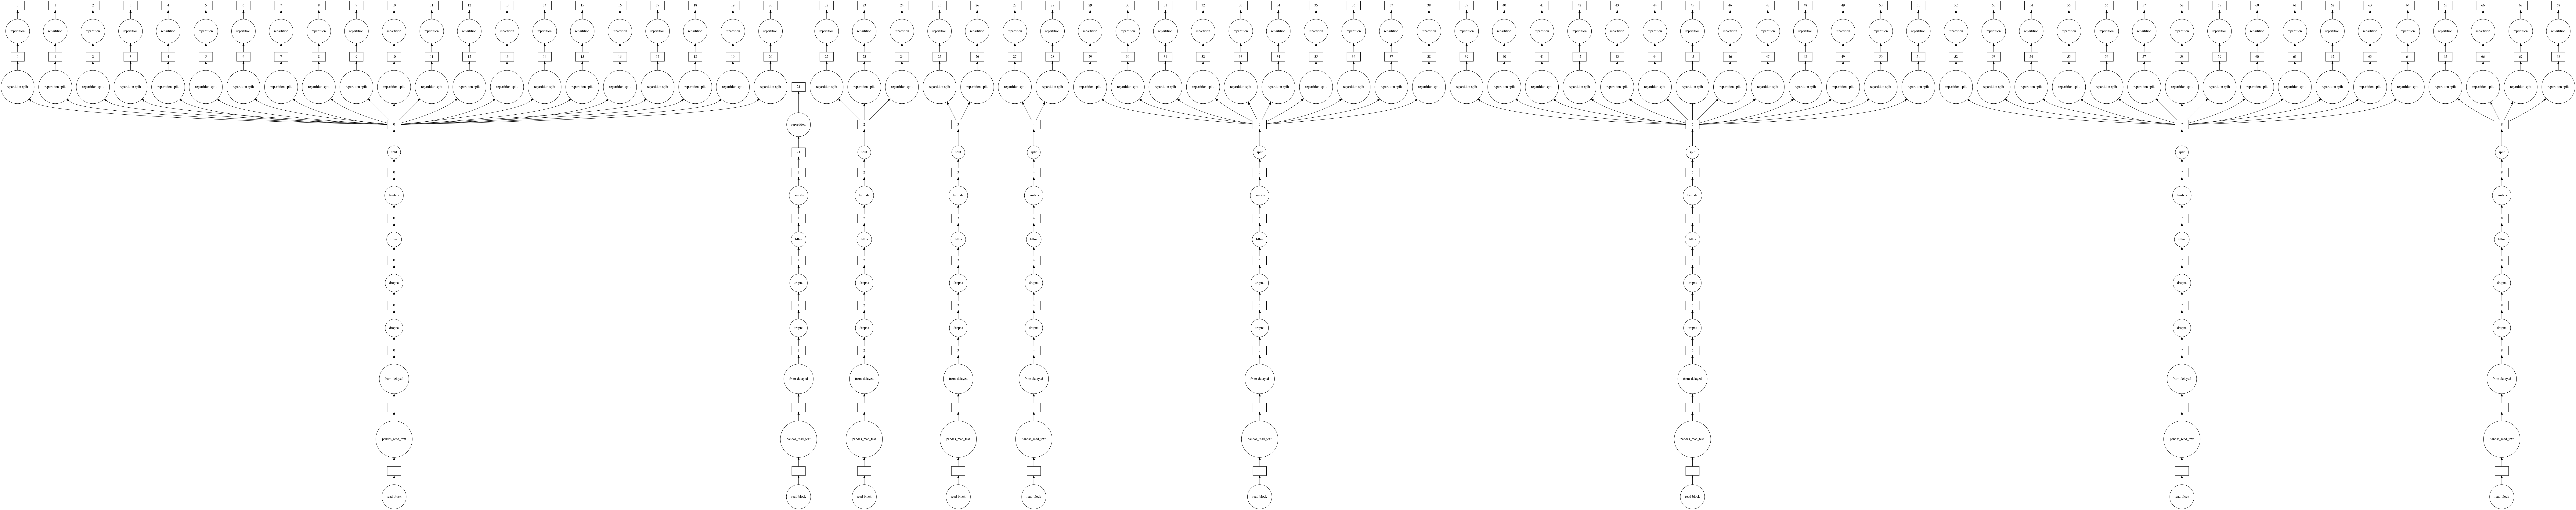

In [6]:
%%time

metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(body=retrieve_paper_body_text_for_series(df.pdf_json_files))
)
print(f"Num partitions before: {metadata_dd.npartitions}")
metadata_dd = metadata_dd.repartition(partition_size="100MB")
print(f"Num partitions after: {metadata_dd.npartitions}")
metadata_dd.visualize()

#### Generating TF-IDF Vectors

In [9]:
%%time
import random

rand_partition_num = random.randint(0, metadata_dd.npartitions)
paper_titles = metadata_dd.get_partition(rand_partition_num).compute(scheduler="processes")["title"]

CPU times: user 293 ms, sys: 500 ms, total: 793 ms
Wall time: 35.6 s


In [18]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit_transform(paper_titles).data.nbytes

295704

In [ ]:
%%time

tfidf_vectorizer = TfidfVectorizer()
title_tfidf_dd = metadata_dd.map_partitions(
    lambda df: tfidf_vectorizer.fit_transform(df['title'])
)
# Runs into MemoryError with multiprocessing scheduler
title_tfidf_matrix = title_tfidf_dd.compute(scheduler="processes")

#### Load Deep Neural Net Embeddings (e.g. BERT, DistilBERT, T5, etc.)